# Importing libs and setting some defaults like the plot size and forcing matplotlib to use seaborn color schemes with softer, more palatable colors 

In [1]:
import pandas as pd
from pandas import DataFrame, Series
from numpy import nan
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
plt.rcParams["figure.figsize"] = (24,5)
import seaborn as sns
sns.set()
sns.set(font_scale=1.75)


## Some default styles that will be used for some functions such as tickmarks, labels, etc

In [2]:
cols = [
    "TEST","MAP","SIZE", "TIME"
]
onmodded = pd.read_csv("new_repr.csv", quotechar="'", header=None)

onmodded = onmodded.drop([0],1)
onmodded.columns= cols
onmodded = onmodded.drop([0],0)
onmodded.iloc[:,2:] = onmodded.iloc[:,2:].astype("int32")

# used for plotter and plotter3, but we can't choose nice looking and distinct enough colors to plot 17 different lines.
# ultimately abandoned in favor of the default styles from seaborn
styles = {'absl::flat_hash_map': ["#0000cc"],  # blue
          "absl::node_hash_map'": ["#3366ff"],
          'absl::node_hash_map': ["#99ccff"],

          'google::dense_hash_map': ["#ff0000"],  # reds
          'google::sparse_hash_map': ["#ff6666"],
          'phmap::parallel_flat_hash_map': ["#ff0066"],

          'ska::bytell_hash_map': ["#009933"],  # greens
          'ska::flat_hash_map': ["#33cc33"],
          'ska::unordered_map': ["#99ff66"],

          'tsl::hopscotch_map': ["#9900cc"],  # purples
          'tsl::robin_map': ["#cc33ff"],
          'tsl::sparse_map': ["#cc99ff"],

          'robin_hood::unordered_flat_map': ["#ffcc99"],
          'robin_hood::unordered_node_map': ["#ccff66"],

          'boost::unordered::unordered_map': ["#663300"],  # brown

          'emilib::HashMap': ["#9900cc"],  # purple

          # weird orange
          'phmap::parallel_node_hash_map': ["#ffcc66", "solid"],

          'std::unordered_map': ["#000000", "solid"],  # black
         }
# where to place the x tickmarks and how to label them
ticks = [50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 500000,
600000, 700000, 800000, 900000, 1000000,
2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000, 10000000,
15000000, 20000000, 25000000, 30000000, 35000000, 40000000, 45000000, 50000000]
ticklabels = ['50 K', '100 K',
 '150 K', '200 K', '250 K', '300 K',
 '350 K', '400 K', '0.5 M', '0.6 M',
 '0.7 M', '0.8 M', '0.9 M', '1 M',
 '2 M', '3 M', '4 M', '5 M',
 '6 M', '7 M', '8 M', '9 M',
 '10 M', '15 M', '20 M', '25 M',
 '30 M', '35 M', '40 M', '45 M', '50 M']
# convenient way to label the plots for later
labels = {
    'int_delete' : ["mean int deletion time", "deletion time (ns)"],
    'int_insert' : ["mean int insertion time", "insertion time(ns)"],
    'int_nosucc_lookup' : ["mean int unsucessful lookup time", "unsucessful lookup time (ns)"],
    'int_succ_lookup' : ["mean int succesful lookup time", "succesful lookup time (ns)"],
    'string_delete' : ["mean string deletion time", "deletion time (ns)"],
    'string_insert' : ["mean string insertion time", "insertion time(ns)"], 
    'string_nosucc_lookup' : ["mean string unsucessful lookup time", "unsucessful lookup time (ns)"],
    'string_succ_lookup' : ["mean string succesful lookup time", "succesful lookup time (ns)"]
}

### Function definitions
Some functions that accept and delete outliers in a range  
A function that removes outliers with the functions mentioned above  
Some helper functions  
Some plotter functions  

In [3]:
# outlier testing functions
def remove_with_modified_z_score(data, treshold=3.5):
    # https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm
    data = data.astype(int)
    stats = data.describe()
    median_absolute_deviation = abs(data - data.median()).median()
    if not median_absolute_deviation:
        return data
    modified_z_scores = abs(0.6745 * (data - data.median()) / median_absolute_deviation)
    cutoff = modified_z_scores <= treshold
    data = data * cutoff
    data = data.replace(0, nan)
    return data

#function that takes one of the outlier testers and data, and removes outliers
# originally, we had multiple outlier tests we tried out and this made it convenient to check the differences
# now it's just the modified_z_score, which we chose
def remove_outlier(data, function):
    new_data = data.copy(True)
    new_data["TIME"] = new_data["TIME"].astype(int)
    new_data["SIZE"] = new_data["SIZE"].astype(int)
    new_data
    for i in range(4216):
        start = i * 30
        end = start+30
        new_data.loc[start:end, "TIME"] = function(data.loc[start:end, "TIME"])
        if not i % 420:
            print(i / 42 , "% done")
    return new_data


# helpers for plot functions
def sort_maps(test):
    maps = data[data["TEST"]== test]["MAP"].unique()
    new = [(gr_max.loc[test, i]["TIME"], i) for i in maps]
    new.sort()
    new = [i[1] for i in new]
    return new

def divider(df, maplist):
    filters = df['MAP'].isin(maplist)
    return df[filters]




# These are in no way optimized
# way too slow for normal use
# And not particularly reusable

def plotter(test, groups):
    maps = sort_maps(test)
    plot_now = [5,11,16]
#     plot_now = [2,5,8,11,14,16]

    for mp in range(0,17):
        map_data = groups.get_group(('int_insert', maps[mp]))        
        sns.lineplot(x="SIZE", y="TIME", data=map_data, err_style="bars", color=styles[maps[mp]][0], label=maps[mp], linestyle="--")
#         sns.lmplot(x=map_data["SIZE"], y=map_data["TIME"], color=styles[maps[mp]][0], label=maps[mp])
        if mp in plot_now:
            plt.xscale("log")
            plt.xticks(ticks, ticklabels)
            plt.set_xticklabels(rotation=45)
            plt.ylabel(labels[test][1])
            plt.legend()
            plt.title(labels[test][0])
            plt.show()

def plotter2(test, data):
    mydata = data[data["TEST"] == test]
    maps = sort_maps(test)
    set1 = divider(mydata, maps[:5])
    set3 = divider(mydata, maps[12:])
    # ^ updated this to only do the top 5 and bottom 5
    plot = sns.lineplot(x="SIZE", y="TIME", hue="MAP", data=set1, ci=95) # < updated to use 95% CI
    plt.xscale("log")
    plt.xticks(ticks, ticklabels)
    plot.set_xticklabels(
        plot.get_xticklabels(), 
        rotation=55, 
        horizontalalignment='center',
        fontweight='light',
    )
    plt.ylabel(labels[test][1])
    plt.legend()
    plt.title(labels[test][0])
    plt.show()
    
    plot = sns.lineplot(x="SIZE", y="TIME", hue="MAP", data=set3, ci=95) # < updated to use 95% CI
    plt.xscale("log")
    plt.xticks(ticks, ticklabels)
    plot.set_xticklabels(
        plot.get_xticklabels(), 
        rotation=55, 
        horizontalalignment='center',
        fontweight='light',
    )
    plt.ylabel(labels[test][1])
    plt.legend()
    plt.title(labels[test][0])
    plt.show()

    
def plotter3(test, groups):
    maps = sort_maps(test)
    plot_now = [5,11,16]
#     plot_now = [2,5,8,11,14,16]
    for mp in range(0,17):
        map_data = groups.get_group(('int_insert', maps[mp]))    
        sns.lineplot(x="SIZE", y="TIME", data=map_data, err_style="band", color=styles[maps[mp]][0], label=maps[mp], linestyle="--")
#         sns.regplot(x="SIZE", y="TIME", color=styles[maps[mp]][0],label=maps[mp], data=map_data)
        if mp in plot_now:
            plt.xscale("log")
            plt.xticks(ticks, ticklabels)
            plt.ylabel(labels[test][1])
            plt.legend()
#             plt.set_xticklabels(rotation=45)
            plt.title(labels[test][0])
            plt.show()


* Remove the outliers
* group the data by test and map, in case plotter or plotter3 is used
* compute means and max of the map

In [4]:
data = remove_outlier(onmodded, remove_with_modified_z_score)
groups = data.groupby(["TEST", "MAP"])
gr_max = groups.max()
gr_mean = groups.mean()
tests = data["TEST"].unique()

0.0 % done
10.0 % done
20.0 % done
30.0 % done
40.0 % done
50.0 % done
60.0 % done
70.0 % done
80.0 % done
90.0 % done
100.0 % done


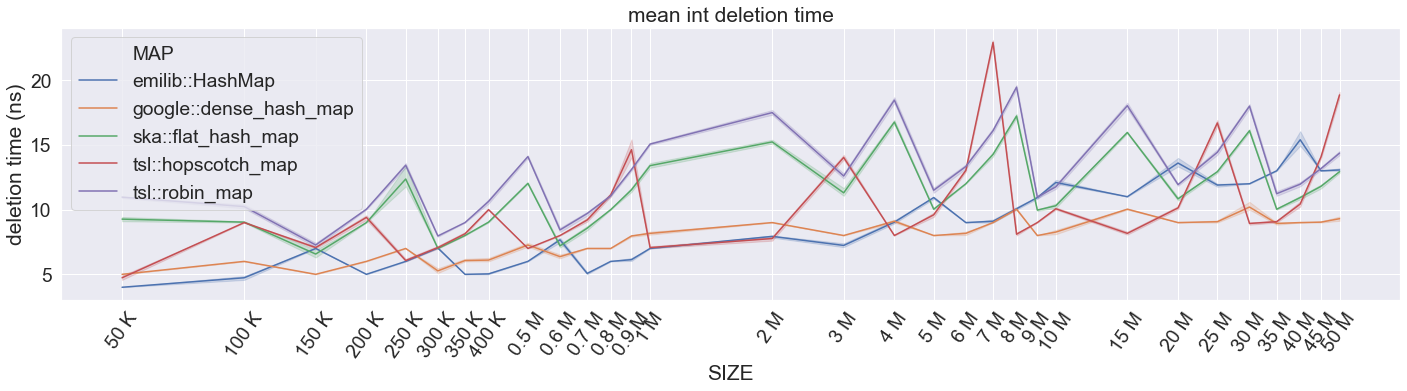

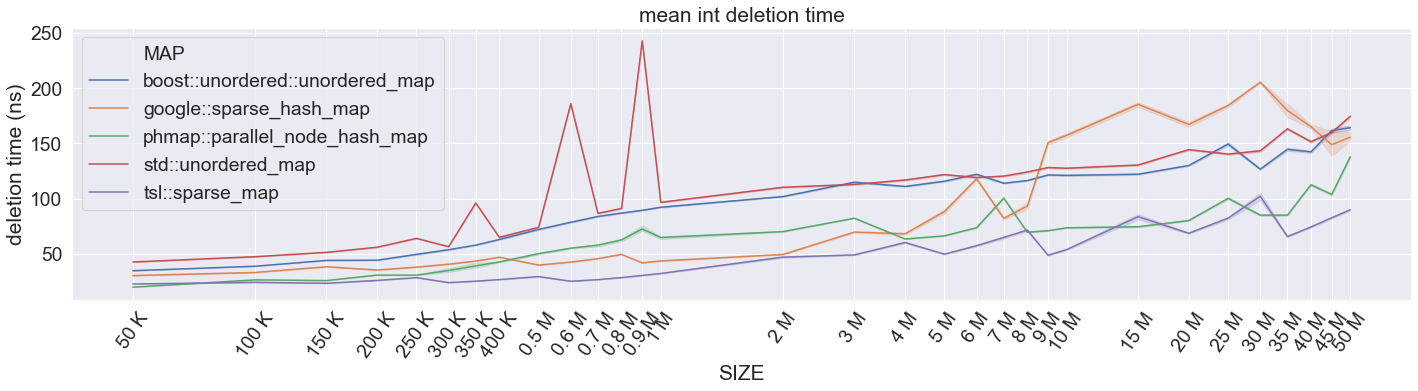

In [5]:
plotter2(tests[0], data)

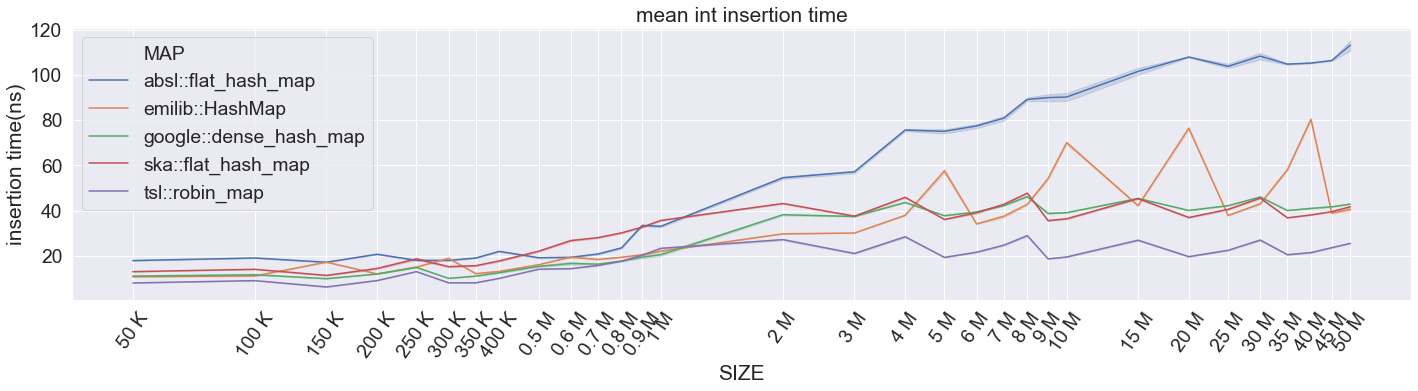

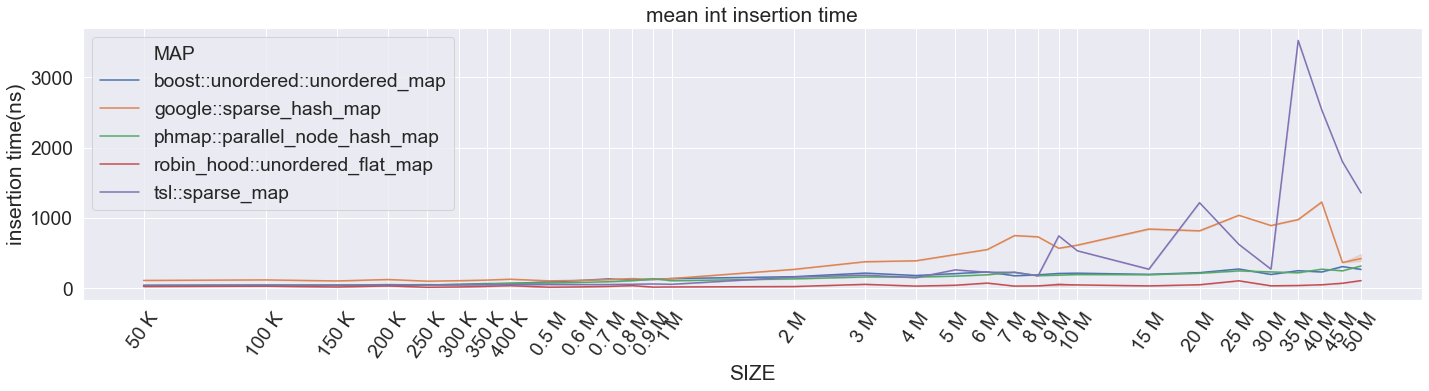

In [6]:
plotter2(tests[1], data)

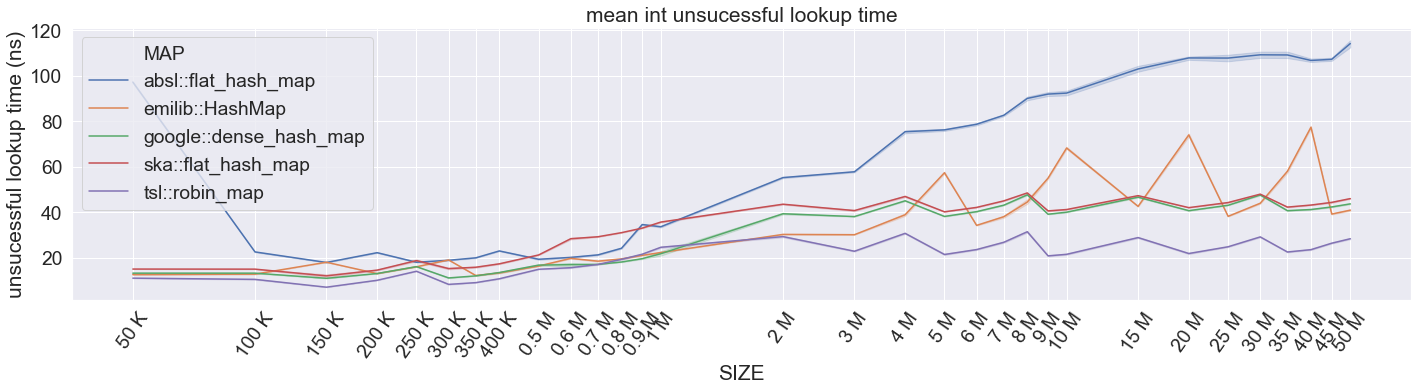

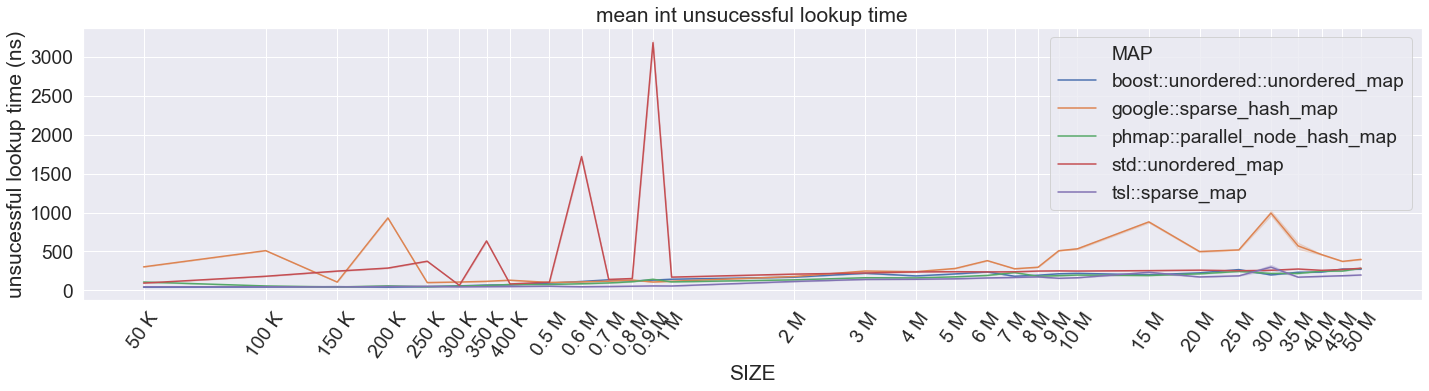

In [7]:
plotter2(tests[2], data)

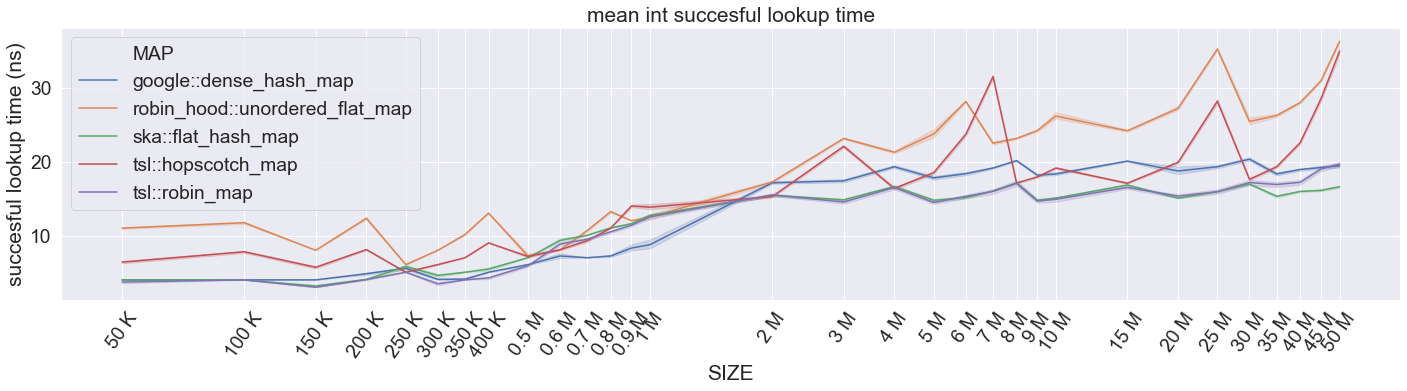

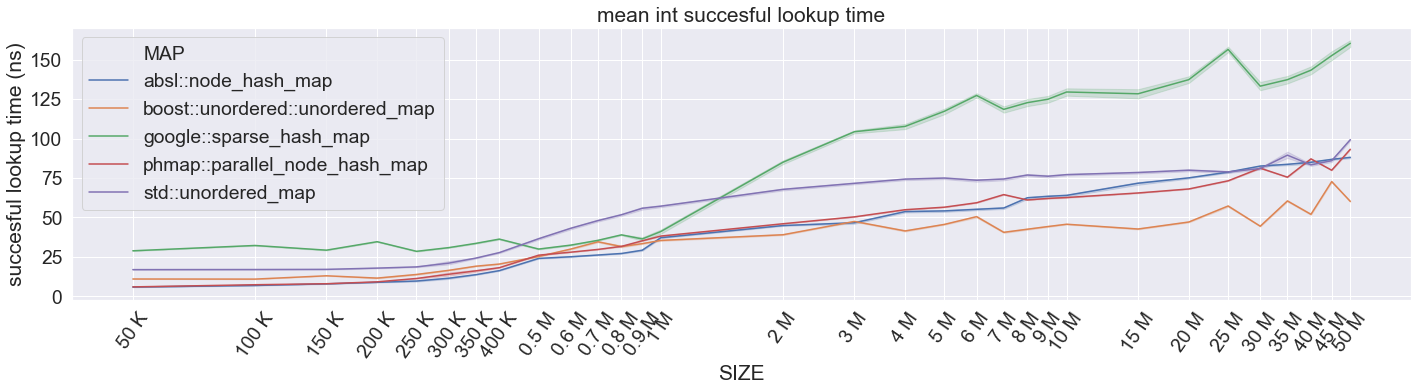

In [8]:
plotter2(tests[3], data)

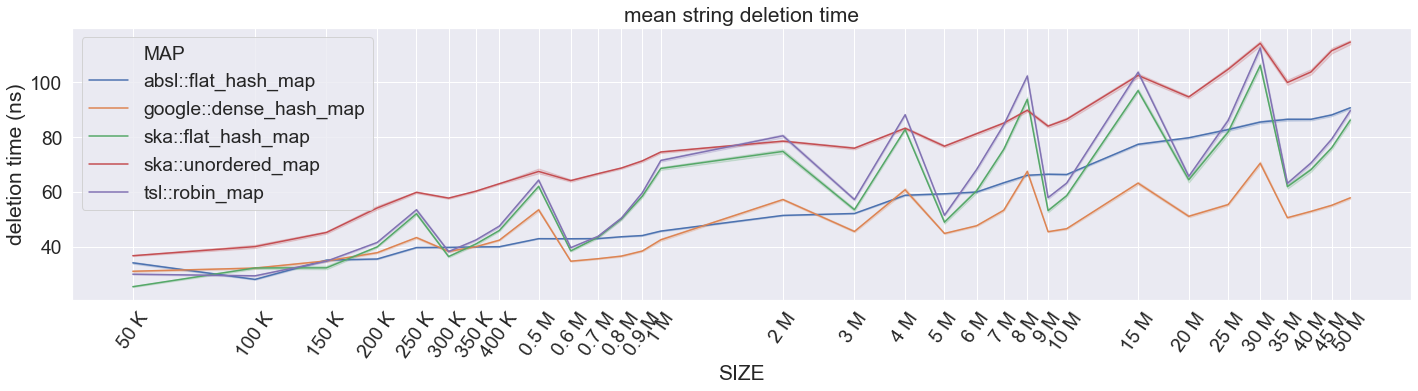

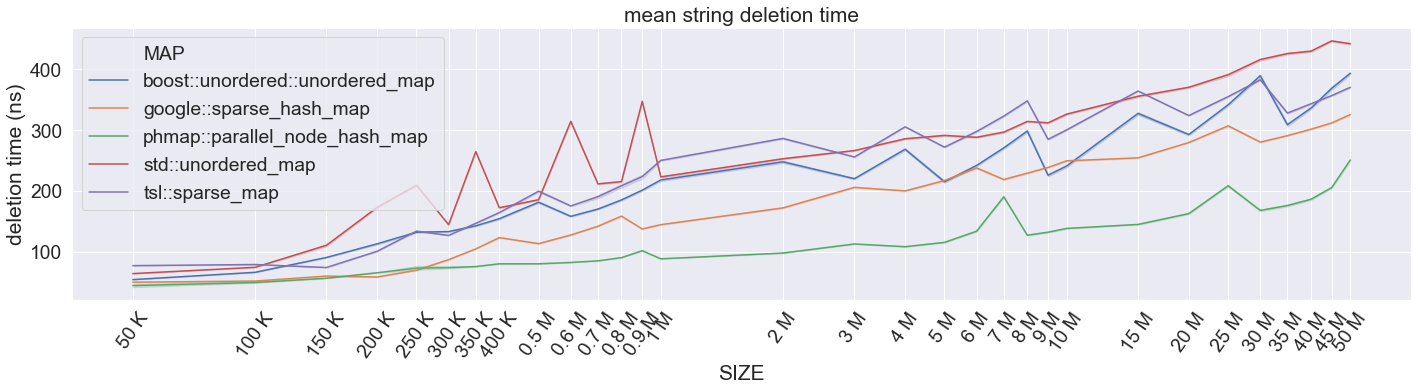

In [9]:
plotter2(tests[4], data)

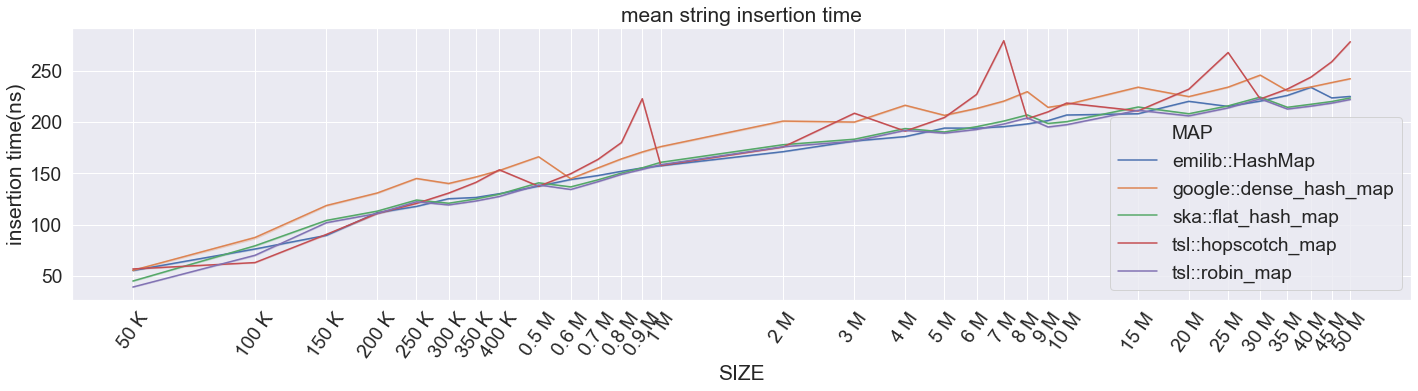

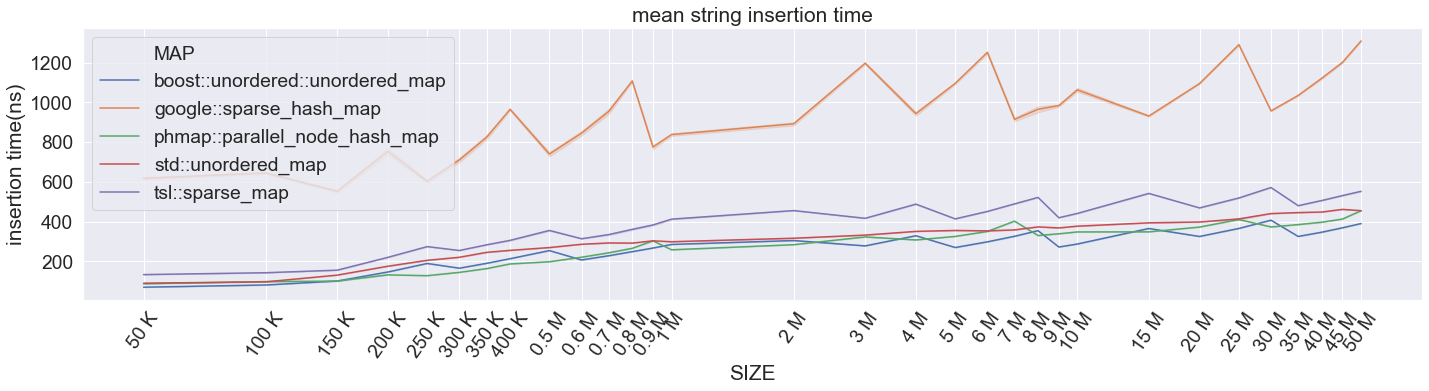

In [10]:
plotter2(tests[5], data)

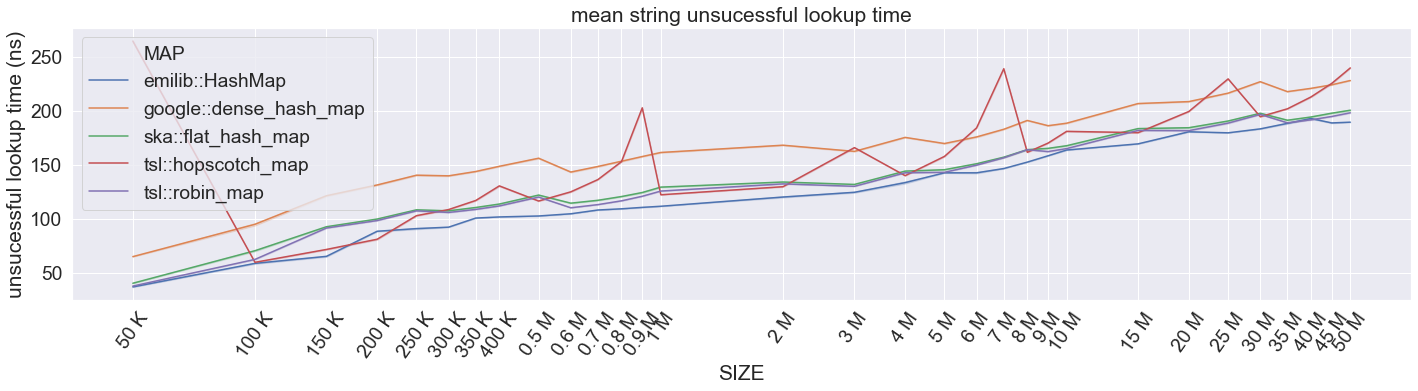

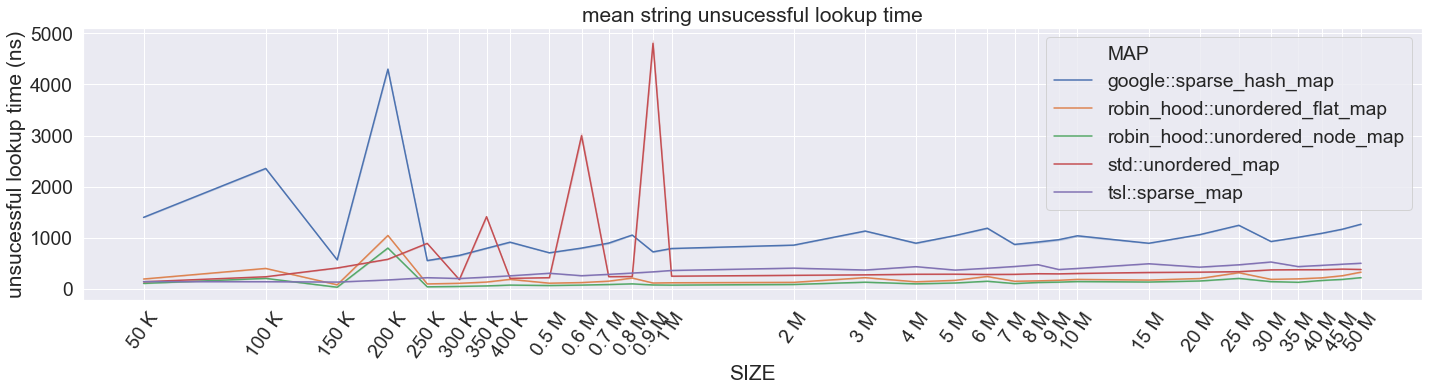

In [11]:
plotter2(tests[6], data)

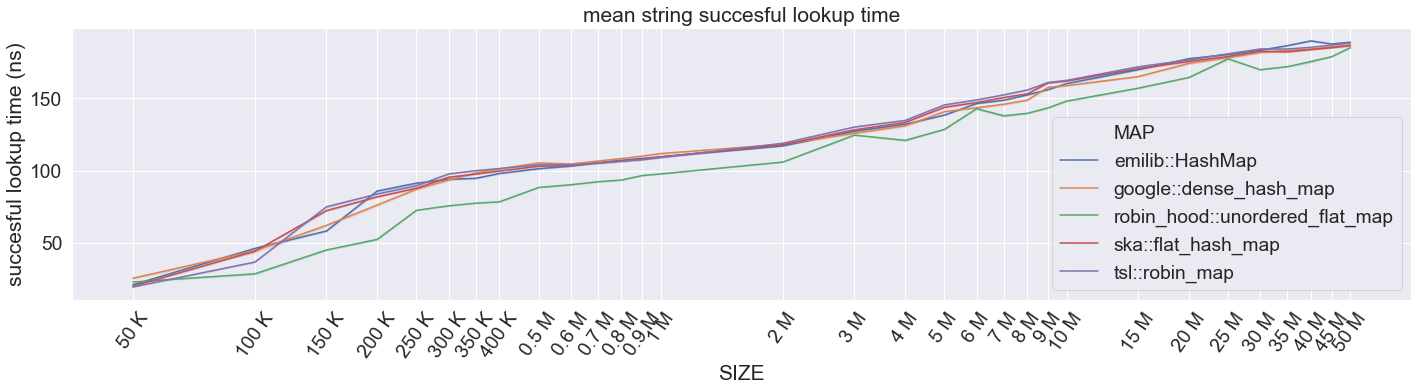

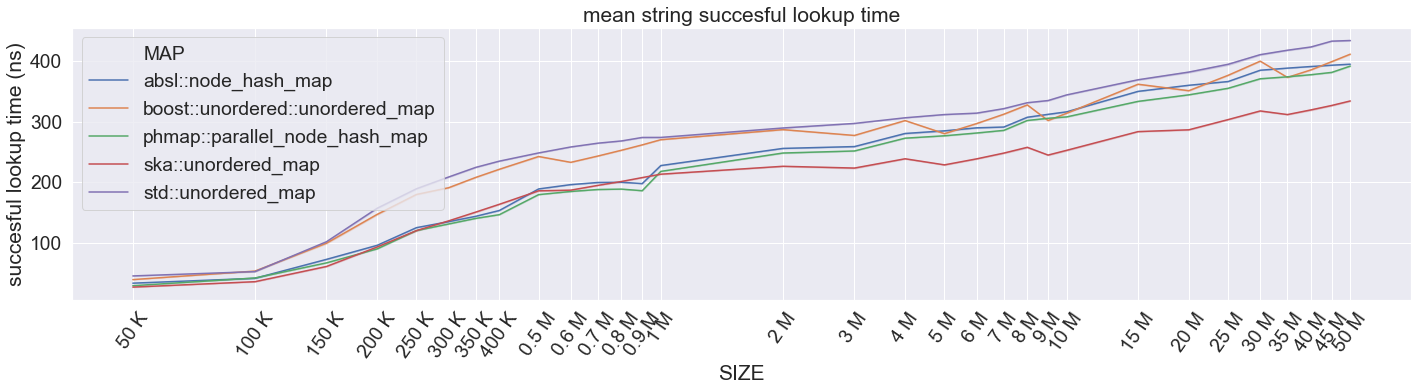

In [12]:
plotter2(tests[7], data)

In [13]:
data["MAP"].unique()

array(['absl::flat_hash_map', 'absl::node_hash_map',
       'boost::unordered::unordered_map', 'emilib::HashMap',
       'google::dense_hash_map', 'google::sparse_hash_map',
       'phmap::parallel_flat_hash_map', 'phmap::parallel_node_hash_map',
       'robin_hood::unordered_flat_map', 'robin_hood::unordered_node_map',
       'ska::bytell_hash_map', 'ska::flat_hash_map', 'ska::unordered_map',
       'std::unordered_map', 'tsl::hopscotch_map', 'tsl::robin_map',
       'tsl::sparse_map'], dtype=object)

Quick way of getting the mean time of each operation and map (for all sizes)  
This number is totally meaningless on it's own, and the absolute values (in ns) should just not be mentioned
I think it's meaningless to mention that the mean insertion time of a map is 50ns between sizes 50K and 50M.
It "loses" so much info.  
But it is a decent use to rank the maps on.  
Eventhough it is somewhat biased towards maps that perform decently at large sizes. Or in other words, this ranking makes the fact that a function is blazing fast for small sizes matter way less.  
This is due to the following:
lets say there are 5 measuring points below 1M, and 20 measuring points between 1M and 50M
when that is averaged, way more points will be >1M, so they will weight more for the mean.

But the graphs are pretty hard to get a quick overview of after a quick glance, so this is my best attempt to create a summary of the relative rankings.
And I don't have the slightest idea how you would rank them besides a mean value. A max value would be a good idea, except that there's random spiky behavour which have higher values in the middle than at 50M. And it's even less representative of the times as a whole compared to the mean. So we have this. 

In [14]:
test = "string_insert"
alpha_maps = gr_mean.loc[test]["TIME"].index
rank = list(gr_mean.loc[test]["TIME"].sort_values().index) # sort by mean
rank = [rank.index(i) for i in alpha_maps] # get the index for each map in alphamaps
for i in rank:
    print(i + 1)

11
9
13
4
6
17
12
14
7
1
8
3
10
15
5
2
16


In [15]:
alpha_maps

Index(['absl::flat_hash_map', 'absl::node_hash_map',
       'boost::unordered::unordered_map', 'emilib::HashMap',
       'google::dense_hash_map', 'google::sparse_hash_map',
       'phmap::parallel_flat_hash_map', 'phmap::parallel_node_hash_map',
       'robin_hood::unordered_flat_map', 'robin_hood::unordered_node_map',
       'ska::bytell_hash_map', 'ska::flat_hash_map', 'ska::unordered_map',
       'std::unordered_map', 'tsl::hopscotch_map', 'tsl::robin_map',
       'tsl::sparse_map'],
      dtype='object', name='MAP')